# Оптимизация производства золотодобывающей компании

#### Описание проекта

Используя данные с параметрами добычи и очистки, построить модель, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

### Описание данных

#### Технологический процесс:

* `Rougher feed` — исходное сырье
* `Rougher additions (или reagent additions)` — флотационные реагенты: Xanthate, Sulphate, Depressant
    * `Xanthate` — ксантогенат (промотер, или активатор флотации);
    * `Sulphate` — сульфат (на данном производстве сульфид натрия);
    * `Depressant` — депрессант (силикат натрия).
* `Rougher process (англ. «грубый процесс»)` — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота

#### Параметры этапов:

* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи

#### Наименование признаков:

Наименование признаков образуется следующим образом: `[этап].[тип_параметра].[название_параметра]`

Возможные значения для блока `[этап]`:

* `rougher` — флотация
* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики


#### План работы над проектом :

   1. [Подготовка данных:](#Step_1)
       * [Обзор и загрузка данных](#Step_1_1)
       * [Проверка корректности данных по эффективности обогащения чернового концентрата](#Step_1_2)
       * [Анализ признаков, недоступных в тестовой выборке](#Step_1_3)
       * [Обработка пропусков](#Step_1_4)
       * [Вывод](#Step_1_5)
   2. [Анализ данных](#Step_2)
       * [Оценка изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#Step_2_1)
       * [Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#Step_2_2)
       * [Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах](#Step_2_3)
       * [Вывод](#Step_2_4)
   3. [Построение модели](#Step_3)
       * [Создание функции для вычисления итоговой sMAPE](#Step_3_1)
       * [Обучение разных моделей и оценка их качества кросс-валидацией](#Step_3_2)
       * [Проверка лучшей модели на тестовых данных](#Step_3_3)
       * [Вывод](#Step_3_4)
   4. [Общий вывод](#Step_4)

# 1. Подготовка данных

### 1.1 Обзор и загрузка данных <a id="Step_1_1"></a>

Загрузим необходимые для работы модули и библиотеки.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 16, 7

#  Подключаем модуль управления тиками:
import matplotlib.ticker as ticker

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Метрики
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import make_scorer

# Кросс - валидация
from sklearn.model_selection import cross_val_score

#Стандартизация
from sklearn.preprocessing import StandardScaler 

Откроем файл с данными и изучим общую информацию.

*Обучающая выборка*

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
pd.options.display.max_columns = None

In [4]:
display(df_train)
df_train.info()
df_train.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,15598.000000,16860.000000,15875.000000,16778.000000,16502.000000,16224.000000,16778.000000,16777.000000,16761.000000,16579.000000,16777.000000,16820.000000,16827.000000,16820.000000,16833.000000,16822.000000,16833.000000,16821.000000,16833.000000,1.683300e+04,1.683300e+04,1.683300e+04,15618.000000,16778.000000,16632.000000,16347.000000,16443.000000,16568.000000,16777.000000,15816.000000,16514.000000,16237.000000,14956.000000,16778.000000,16778.000000,16698.000000,16778.000000,14287.000000,14610.000000,16778.000000,14611.000000,14611.000000,16807.000000,16807.000000,16807.000000,16807.000000,16807.000000,16814.000000,16802.000000,16809.000000,16257.000000,16809.000000,16802.000000,16802.000000,16776.000000,16764.000000,14874.000000,16778.000000,16497.000000,16751.000000,16705.000000,16748.000000,16763.000000,16747.000000,16752.000000,16750.000000,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775

*Тестовая выборка*

In [5]:
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

In [6]:
display(df_test)
df_test.info()
df_test.describe()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5816.000000,5834.000000,5789.000000,5840.000000,5599.000000,5733.000000,5801.000000,5503.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5836.000000,5840.000000,5833.000000,5840.000000,5822.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,1486.398557,-510.723606,8.736170,3.552722,458.485472,55.937535,35.105834,8.700930,13.439933,6.169553,13.056047,6.423566,1016.294703,-404.977728,1270.598553,-482.154567,1253.495045,-480.945868,1169.675564,-482.152253,1018.386311,-476.551547,962.005375,-477.795380,25.479808,-513.714941,21.083475,-512.325717,24.345831,-519.417733,20.068079,-515.028316,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,313.725248,65.417633,2.985805,1.326113,155.958272,22.724254,10.793249,2.803046,3.997715,1.673606,4.533948,1.120371,226.494775,100.953782,285.247715,55.399631,290.703157,53.759053,285.407244,54.967985,231.675756,67.002595,220.862435,68.342305,5.450424,62.448366,5.940017,63.376776,7.950733,73.968109,7.644391,60.457838,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,0.000000,-799.838846,0.000000,0.000000,0.002986,0.046369,0.000000,0.000000,0.000154,0.000052,0.000014,0.000055,-0.123194,-657.949759,-0.821921,-650.349159,-0.282087,-650.000000,-1.047388,-648.390665,-2.076798,-650.152533,-2.593390,-650.034631,0.000000,-799.608557,0.000000,-798.467243,0.000000,-799.7

*Все данные*

In [7]:
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [8]:
display(df_full)
df_full.info()
df_full.describe()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,21170.000000,22716.000000,21565.000000,22618.000000,22268.000000,21918.000000,22618.000000,22614.000000,22594.000000,22365.000000,22617.000000,22660.000000,22667.000000,22660.000000,22673.000000,22662.000000,22673.000000,22661.000000,22673.000000,2.267200e+04,2.267200e+04,2.267200e+04,21089.000000,22618.000000,22472.000000,22163.000000,22277.000000,22357.000000,22617.000000,21415.000000,22247.000000,22038.000000,20459.000000,22618.000000,22618.000000,22526.000000,22618.000000,19597.000000,19979.000000,22618.000000,19980.000000,19980.000000,22646.000000,22647.000000,22646.000000,22647.000000,22646.000000,22654.000000,22641.000000,22649.000000,22096.000000,22649.000000,22641.000000,22642.000000,22616.000000,22600.000000,20501.000000,22618.000000,22333.000000,22591.000000,22538.000000,22588.000000,22585.000000,22587.000000,22592.000000,22590.000000,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615

Мы загрузили все имеющиеся у нас данные и необходимые для дальнейшей работы библиотеки. 
* Первое, что бросается в глаза, это пропуски. 
* Второй момент - отсутствие в тестовой выборке признаков, отвещающих за информацию относительно содержания элементов продукте/хвостах после каждой стадии, а также отсутствие расчётных параметров.
* Третье - точки в заголовках, которые стоит заменить на нижнее подчеркивание.

### 1.2 Проверка корректности данных по эффективности обогащения чернового концентрата <a id="Step_1_2"></a>

Вычислим эффективность обогащения чернового концентрата на обучающей выборке `df_train` для признака `rougher.output.recovery`.

Эффективность обогащения чернового концентрата рассчитывается по следующей формуле: 

`Recovery = C * (F - T) / F * (C - T) * 100%`

, где: 

* `C` — доля золота в концентрате после флотации - `rougher.output.concentrate_au`
* `F` — доля золота в сырье до флотации - `rougher.input.feed_au`
* `T` — доля золота в отвальных хвостах после флотации - `rougher.output.tail_au`

В контексте решения задачи по расчёту `MAE` создадим отдельный датасет, в котором удалим существующие пропуски.

In [9]:
df_recovery = df_train.loc[:,['rougher.output.recovery'
                                ,'rougher.output.concentrate_au'
                                ,'rougher.input.feed_au'
                                ,'rougher.output.tail_au']]

In [10]:
df_recovery = df_recovery.dropna()

In [11]:
df_recovery.isna().sum().sum()

0

Датасет создан, пропуски отсутствуют, приступаем к расчётам. 

Для простоты восприятия создадим соответствующие переменные из имеющихся столбцов и подставим их в формулу.

In [12]:
C = df_recovery['rougher.output.concentrate_au'] 
F = df_recovery['rougher.input.feed_au'] 
T = df_recovery['rougher.output.tail_au']
target = df_recovery['rougher.output.recovery']

In [13]:
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100

Теперь рассчитаем метрику MAE 

In [14]:
MAE = mean_absolute_error(target, calculated_recovery)

print(MAE)

9.303415616264301e-15


Учитывая, что `MAE` - это среднее абсолютное отклонение, получив результат для неё `9.444891926100695e-15`, можно с уверенностью говорить о том, что эффективность обогащения чернового концентрата, исходя из имеющихся данных, рассчитана верно. 

### 1.3 Анализ признаков, недоступных в тестовой выборке <a id="Step_1_3"></a>

Как уже было сказано в пункте `1.1`, в тестовой выборке отсутствуют данные относительно параметров сырья, прошедшего каждый из этапов переработки (флотацию, первый этап очистки, второй этап очистки), а именно:

Эффективность обогащения финального концентрата: 
* `final.output.recovery`

Эффективность обогащения сырья после флотации: 
* `rougher.output.recovery`

Концетрация элементов в продукте, прошедшем все стадии очистки: 
* `final.output.concentrate_ag`
* `final.output.concentrate_pb`
* `final.output.concentrate_sol`
* `final.output.concentrate_au`

Концетрация элементов в отвальных хвостах, после всех стадий очистки: 
* `final.output.tail_ag`
* `final.output.tail_pb`
* `final.output.tail_sol`
* `final.output.tail_au`

Концетрация элементов в продукте, прошедшем флотацию: 
* `rougher.output.concentrate_ag`
* `rougher.output.concentrate_pb`
* `rougher.output.concentrate_sol`
* `rougher.output.concentrate_au`

Концетрация элементов в отвальных хвостах, после флотации: 
* `rougher.output.tail_ag`
* `rougher.output.tail_pb`
* `rougher.output.tail_sol`
* `rougher.output.tail_au`

Концетрация элементов в продукте, прошедшем первую стадию очистки:
* `primary_cleaner.output.concentrate_ag`
* `primary_cleaner.output.concentrate_pb`
* `primary_cleaner.output.concentrate_sol`
* `primary_cleaner.output.concentrate_au`

Концетрация элементов в отвальных хвостах, после первой стадии очистки: 
* `primary_cleaner.output.tail_ag`
* `primary_cleaner.output.tail_pb`
* `primary_cleaner.output.tail_sol`
* `primary_cleaner.output.tail_au`

Концетрация элементов в отвальных хвостах, после второй стадии очистки: 
* `secondary_cleaner.output.tail_ag`
* `secondary_cleaner.output.tail_pb`
* `secondary_cleaner.output.tail_sol`
* `secondary_cleaner.output.tail_au`

Обобщая, можно утверждать, что в тестовый выборке присутствуют признаки, которые являются причиной, а признаки, которые можно было бы отнести к результатам - отсутствуют.

Другими словами, в тестовой выборке находятся признаки, на которых мы будем обучать модель.

Целевыми признаками будут `final.output.recovery` и `rougher.output.recovery`, которые необходимо перенести в тестовую выборку из `df_full`.

### 1.4 Обработка пропусков <a id="Step_1_4"></a>

Начнём с того, что для каждой из выборок заменим в названии столбцов точки на нижнее подчеркивание.

In [15]:
df_train.columns = df_train.columns.str.replace('.', "_") 

/tmp/ipykernel_308/3748709603.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_train.columns = df_train.columns.str.replace('.', "_")


In [16]:
df_test.columns = df_test.columns.str.replace('.', "_") 

/tmp/ipykernel_308/2512667037.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_test.columns = df_test.columns.str.replace('.', "_")


In [17]:
df_full.columns = df_full.columns.str.replace('.', "_") 

/tmp/ipykernel_308/1500004280.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_full.columns = df_full.columns.str.replace('.', "_")


В случае технологического процесса мы имеем дело с временными рядами, следовательно для заполнения имеющихся пропущенных значений воспользуемся методом `Last observation carried forward / Повторение результата последнего наблюдения`.

*Обучающая выборка*

In [18]:
df_train = df_train.fillna(method = 'ffill', limit = 3)

In [19]:
df_train.isna().sum().sort_values(ascending = False).head(5)

rougher_output_recovery               1979
rougher_output_tail_ag                1862
rougher_output_tail_sol               1861
rougher_output_tail_au                1861
rougher_input_floatbank11_xanthate    1615
dtype: int64

Чтобы несколько смягчить искажение от заполнения пропусков предыдущим значением, воспользуемся аналогичной операцией, только заполнять будем наоборот: от имеющегося значения - предшествующие.

In [20]:
df_train = df_train.fillna(method = 'bfill', limit = 3)

In [21]:
df_train.isna().sum().sort_values(ascending = False).head(5)

rougher_output_recovery               1729
rougher_output_tail_ag                1645
rougher_output_tail_au                1644
rougher_output_tail_sol               1644
rougher_input_floatbank11_xanthate    1440
dtype: int64

Остановимся на 6 подряд искуственно заполненных пропусках. Оставшиеся пропуски удалим.

In [22]:
df_train = df_train.dropna()

In [23]:
df_train.isna().sum().sum()

0

Оценим процент потерянных данных для выборки `df_train` после удаления пропусков.

In [24]:
df_train.shape

(12945, 87)

In [25]:
print('Доля потерянных данных: {:.2%}'.format((16860 - 12945) / 16860))

Доля потерянных данных: 23.22%


С одной стороны, достаточно высокий процент данных, которые пришлось удалить. С другой - качество модели и весь последующий анализ от более чистых данных существенно выигрывают, что является более весомым аргументом в пользу выполненных операций, чем искусственное заполнение пропусков, которое в итоге приведёт к снижению предиктивных возможностей финальной модели.

*Тестовая выборка*

Прежде, чем произвести заполнение пропусков в выборке `df_test`, добавим в неё целевые признаки `final_output_recovery` и `rougher_output_recovery` из `df_full`.

In [26]:
df_full_slice = df_full.loc[:,['date'
                               ,'final_output_recovery'
                               ,'rougher_output_recovery']]                                                                                                                                                                                                                                                

In [27]:
df_test = df_test.merge(df_full_slice, on='date', how='left')

Далее заполним пропуски по аналогии с обучающей выборкой.

In [28]:
df_test = df_test.fillna(method = 'ffill', limit = 1)

In [29]:
df_test.isna().sum().sort_values(ascending = False).head(5)

rougher_output_recovery               457
final_output_recovery                 392
rougher_input_floatbank11_xanthate    318
primary_cleaner_input_depressant      254
primary_cleaner_input_sulfate         253
dtype: int64

In [30]:
df_test = df_test.fillna(method = 'bfill', limit = 1)

In [31]:
df_test.isna().sum().sort_values(ascending = False).head(5)

rougher_output_recovery               413
final_output_recovery                 361
rougher_input_floatbank11_xanthate    292
primary_cleaner_input_depressant      235
primary_cleaner_input_sulfate         226
dtype: int64

Для тестовой выборки ограничимся 2 подряд искусственно заполненными пропусками. По одному с каждой стороны. Остальное, как и в случае с обучающей выборкой, удалим.

In [32]:
df_test = df_test.dropna()

In [33]:
df_test.isna().sum().sum()

0

Оценим процент потерянных данных для выборки `df_test` после удаления пропусков.

In [34]:
df_test.shape

(5395, 55)

In [35]:
print('Доля потерянных данных: {:.2%}'.format((5856 - 5437) / 5856))

Доля потерянных данных: 7.16%


7.16% цифра для нас более чем приемлимая.

### 1.5 Вывод <a id="Step_1_5"></a>

На первом этапе подготовки данных: 
 - загрузили всё необходимое для дальнейшего анализа; 
 - оценили корректность расчёта эффективности обогащения; 
 - определились с признаками для построения модели; 
 - проверили предобработку данных. 

# 2. Анализ данных

### 2.1 Оценка изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки <a id="Step_2_1"></a>

Используя фрейм `df_train`, построим совмещённые по этапам очистки гистограммы по каждому из металлов.

AU

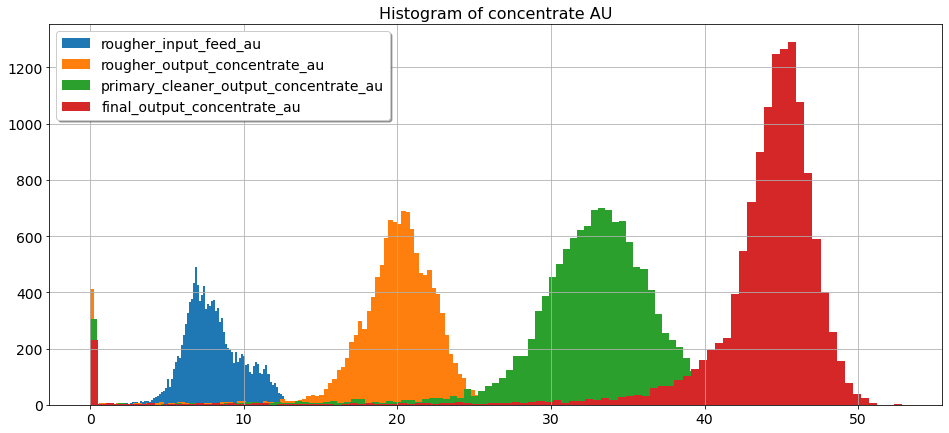

In [36]:
df_train['rougher_input_feed_au'].hist(bins = 100, label = 'rougher_input_feed_au')
df_train['rougher_output_concentrate_au'].hist(bins = 100, label = 'rougher_output_concentrate_au')
df_train['primary_cleaner_output_concentrate_au'].hist(bins = 100, label = 'primary_cleaner_output_concentrate_au')
df_train['final_output_concentrate_au'].hist(bins = 100, label = 'final_output_concentrate_au')

plt.title('Histogram of concentrate AU', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

Помимо большого количества нулевых значений, которые вероятней всего изначально являлись результатом ошибочных измерений либо некорретного отображения/переноса данных, в свою очередь усиленного нами количественно при заполнении пропусков; мы также можем наблюдать явный рост концентрации золота по направлению технологического процесса от поступления сырья до последней стадии очистки. 

AG

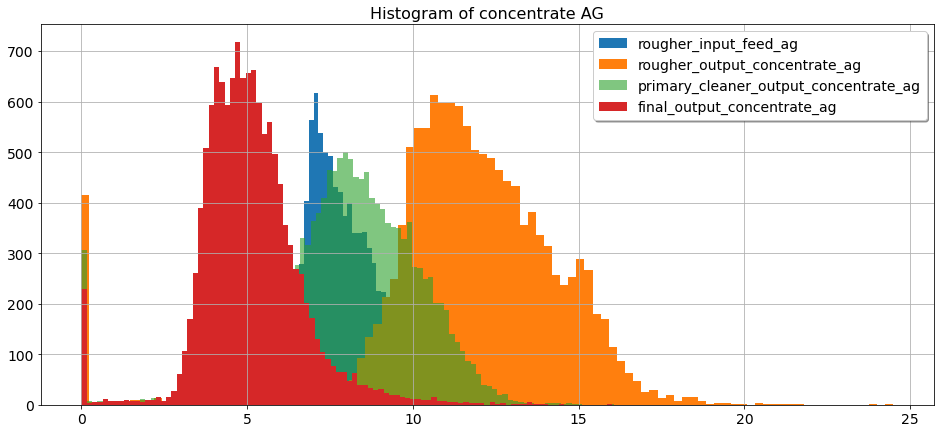

In [37]:
df_train['rougher_input_feed_ag'].hist(bins = 100, label = 'rougher_input_feed_ag')
df_train['rougher_output_concentrate_ag'].hist(bins = 100, label = 'rougher_output_concentrate_ag')
df_train['primary_cleaner_output_concentrate_ag'].hist(bins = 100, label = 'primary_cleaner_output_concentrate_ag', alpha = 0.6)
df_train['final_output_concentrate_ag'].hist(bins = 100, label = 'final_output_concentrate_ag')

plt.title('Histogram of concentrate AG', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

Аналогичная ситуация с нулевыми значениями, а вот изменение содержания серебра уже носит не такой линейный характер, как в случае с золотом. 

Легко можно заметить, что рост концентрации металла происходит только после флотации, далее же идёт ровно обратаная ситуация: с каждой последующей стадией очистки содержание серебра снижается. 

PB

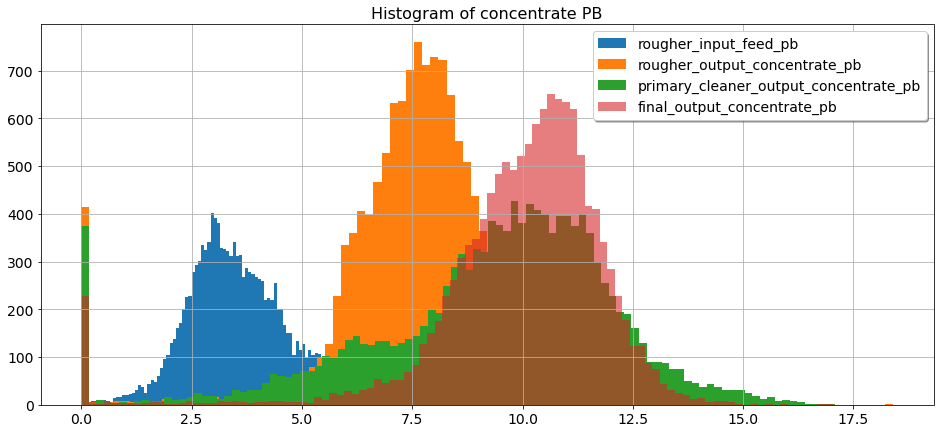

In [38]:
df_train['rougher_input_feed_pb'].hist(bins = 100, label = 'rougher_input_feed_pb')
df_train['rougher_output_concentrate_pb'].hist(bins = 100, label = 'rougher_output_concentrate_pb')
df_train['primary_cleaner_output_concentrate_pb'].hist(bins = 100, label = 'primary_cleaner_output_concentrate_pb')
df_train['final_output_concentrate_pb'].hist(bins = 100, label = 'final_output_concentrate_pb', alpha = 0.6)

plt.title('Histogram of concentrate PB', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

По нулевым значениям ситуация абсолютно та же, а вот по концентрации свинец отличается и от серебра и от золота.

Существенный рост концетрации свинца после флотации, некоторый сдвиг в большую сторону, но с значительным разбросом после первой стадии очистки, и практически тот же уровень концентрации, но с меньшим разбросом после второй.

Таким образом, анализируя гистограммы содержания всех металлов в зависимости от этапа очистки, отметим, что лучший рост от стадии к стадии показывает золото, менее выразительно ведет себя свинец, а вот концентрации серебра и вовсе снижается. 

### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках <a id="Step_2_2"></a>

*Обучающая выборка*

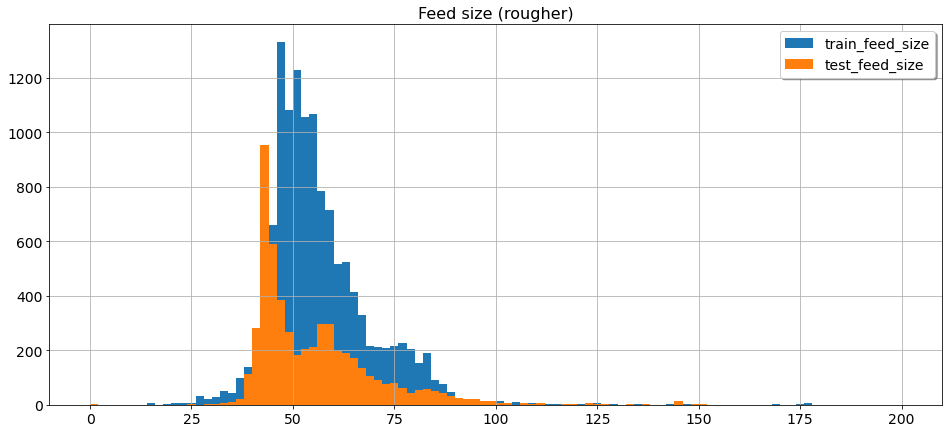

In [39]:
df_train['rougher_input_feed_size'].hist(bins = 100, label = 'train_feed_size', range = (0,200))
df_test['rougher_input_feed_size'].hist(bins = 100, label = 'test_feed_size', range = (0,200))

plt.title('Feed size (rougher)', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

*Тестовая выборка*

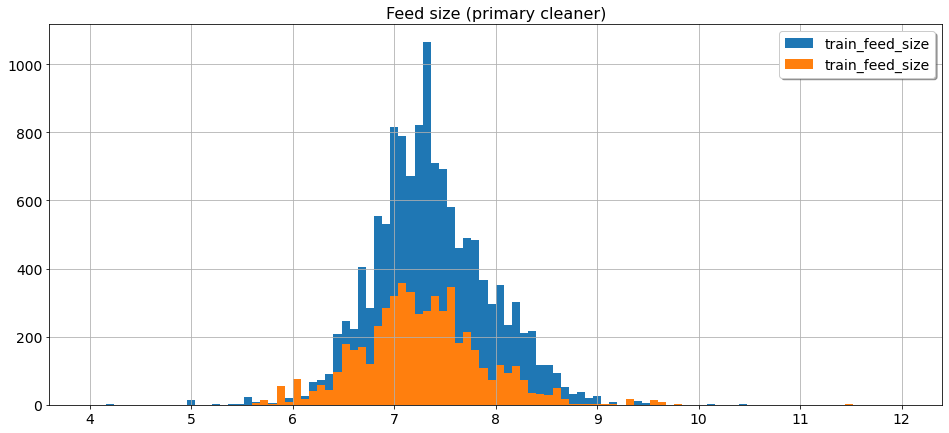

In [40]:
df_train['primary_cleaner_input_feed_size'].hist(bins = 100, label = 'train_feed_size', range = (4,12))
df_test['primary_cleaner_input_feed_size'].hist(bins = 100, label = 'train_feed_size', range = (4,12))

plt.title('Feed size (primary cleaner)', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

И скошенность гистограмм вправо с легким намеком на полимодальность для сырья, и нормальное распределение для первого этапа очистки - в обоих случаях как для обучающей, так и для тестовой выборки, наглядно демонстрируют нам выраженную схожесть распределений размеров гранул.

### 2.3 Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах <a id="Step_2_3"></a>

Сырье

In [41]:
df_train_rougher_input_sum = (df_train['rougher_input_feed_ag'] 
              + df_train['rougher_input_feed_au']
              + df_train['rougher_input_feed_pb']
              + df_train['rougher_input_feed_sol'])

Черновой концентрат

In [42]:
df_train_rougher_output_sum = (df_train['rougher_output_concentrate_au'] 
    + df_train['rougher_output_concentrate_ag']
    + df_train['rougher_output_concentrate_pb']
    + df_train['rougher_output_concentrate_sol'])

Финальный концентрат

In [43]:
df_train_final_sum = (df_train['final_output_concentrate_au'] 
    + df_train['final_output_concentrate_ag']
    + df_train['final_output_concentrate_pb']
    + df_train['final_output_concentrate_sol'])

Суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

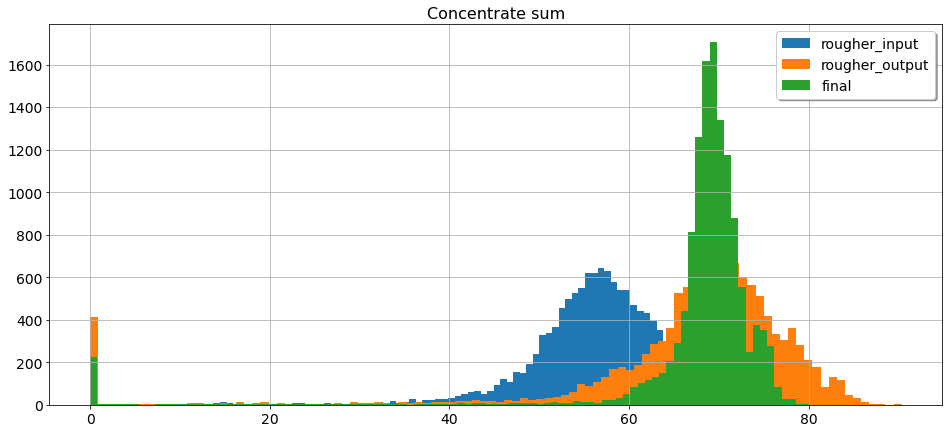

In [44]:
df_train_rougher_input_sum.hist(bins = 100, label = 'rougher_input')
df_train_rougher_output_sum.hist(bins = 100, label = 'rougher_output')
df_train_final_sum.hist(bins = 100, label = 'final')

plt.title('Concentrate sum', fontsize = 16)
plt.legend(shadow = True, fontsize = 14)
plt.tick_params(labelsize = 14)
plt.show()

Из построенного графика хорошо видно, что по направлению технологического процесса концентрация веществ увеличивается, что в целом соответствует общей логике.

Нулевые же значения являются явной ошибкой, следствием некорректного замера и способа заполнения отсутствующих значений.

Так как концентрации элементов в сырье являются признаками, необходимыми для обучения модели, удалим из `df_train` объекты, которым соответствуют нулевые значения этого признака.

Также не оставим без внимания грубые выбросы, которые лежат в 2 раза дальше границы обычной диаграммы размаха. Выбросы внутри этой области сохраним для подготовки модели к реальным условиям, в которых необходимо будет осуществлять прогноз.

In [45]:
df_train['df_train_rougher_input_sum'] = df_train_rougher_input_sum

In [46]:
q1 = df_train['df_train_rougher_input_sum'].quantile(0.25)

In [47]:
q3 = df_train['df_train_rougher_input_sum'].quantile(0.75)

In [48]:
iqr = q3 - q1

In [49]:
lower_bound = q1 - iqr * 3

In [50]:
upper_bound = q3 + iqr * 3

In [51]:
df_train = df_train.query('df_train_rougher_input_sum > @lower_bound and df_train_rougher_input_sum < @upper_bound')

Признак суммарной концентрации веществ в сырье полезной нагрузки для построения моделей в нашем случае более не несёт. Поэтому удалим его.

In [52]:
df_train = df_train.drop(['df_train_rougher_input_sum'], axis = 1)

### 2.4 Вывод <a id="Step_2_4"></a>

На этапе анализа данных: 
 - оценили, что концентрация металлов, за исключением серебра, по направлению тех.процесса возрастает, а лучший результат в этом направлении у золота;
 - установили схожую структуру распределения размеров гранул сырья в обучающей и тестовой выборках;
 - исследовали суммарную концентрацию всех веществ на разных стадиях процесса, результатом чего стало удаление из обучающей выборки сильных выбросов и нулевых значений суммарной концентрации элементов в сырье.

# 3. Модель

### 3.1 Создание функции для вычисления итоговой sMAPE <a id="Step_3_1"></a>

In [53]:
def smape_1 (y_target, y_predict):
    error = (y_target - y_predict).abs()
    scale = (y_target.abs() + y_predict.abs()) / 2 
    result = (error / scale).mean()
    return result * 100 


def final_smape (y_target , y_predict):
    y_target.reset_index(drop = True, inplace = True)
    y_predict = pd.DataFrame(data = y_predict)
    rougher = smape_1(y_target.iloc[:,0], y_predict.iloc[:,0])
    final = smape_1(y_target.iloc[:,1], y_predict.iloc[:,1])
    return 0.25 * rougher + 0.75 * final

In [54]:
my_scorer = make_scorer(final_smape, greater_is_better = False)

### 3.2 Обучение разных моделей и оценка их качества кросс-валидацией <a id="Step_3_2"></a>

В первую очередь оставим в `df_train` только необходимые для построения модели признаки.

In [55]:
columns_1 = df_test.columns.tolist()

In [56]:
df = df_train.drop(columns_1, axis = 1)

In [57]:
columns_2 = df.columns.tolist()

In [58]:
df_train = df_train.drop(columns_2, axis = 1)

In [59]:
df_train.shape

(12663, 55)

Далее разобьём признаки `df_train` на обучающие и целевые.

In [60]:
features_train = df_train.drop(['rougher_output_recovery','final_output_recovery','date'], axis = 1) 
target_train = df_train.loc[:,['rougher_output_recovery','final_output_recovery']]

In [61]:
target_train = target_train.reset_index(drop = True)

In [62]:
features_train = features_train.reset_index(drop = True)

Стандартизируем данные

In [63]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)

Дерево решений (DecisionTreeRegressor)

In [64]:
best_tree_model = None
best_final_score_tree = 30

for depth in range(1,10): 
    
    tree_model = DecisionTreeRegressor(random_state=12345
                                       , max_depth= depth)
    
    final_score_tree =  np.mean(cross_val_score(tree_model
                                      , features_train
                                      , target_train
                                      , scoring = my_scorer
                                      , cv=5)) * (- 1)
    
    if final_score_tree < best_final_score_tree:
        best_tree_model = tree_model
        best_final_score_tree = final_score_tree
        best_depth = depth
        
print("best_tree_model : best_depth =", best_depth,',', end='')
print('best_final_score_tree = ', round(best_final_score_tree,3))

best_tree_model : best_depth = 2 ,best_final_score_tree =  10.816


Случайный лес (RandomForestRegressor)

In [65]:
best_forest_model = None
best_final_score_forest = 30

for est in range(1,150,20): 
    
    forest_model = RandomForestRegressor(random_state=12345
                                       , n_estimators = est)
    
    final_score_forest =  np.mean(cross_val_score(forest_model
                                      , features_train
                                      , target_train
                                      , scoring = my_scorer
                                      , cv=5)) * (- 1)
    
    if final_score_forest < best_final_score_forest:
        best_forest_model = forest_model
        best_final_score_forest = final_score_forest
        best_est = est
        
print("best_forest_model : best_est =", best_est,',', end='')
print('best_final_score_forest = ', round(best_final_score_forest,3))

best_forest_model : best_est = 141 ,best_final_score_forest =  12.31


Линейная регрессия (LinearRegression)

In [66]:
linear_model = LinearRegression()

In [67]:
final_score_linear = np.mean(cross_val_score(linear_model
                                      , features_train
                                      , target_train
                                      , scoring = my_scorer
                                      , cv=5)) * (- 1)

In [68]:
print(final_score_linear)

12.47743999363583


Для наглядности создадим таблицу по полученным результатам для каждой из моделей.

In [69]:
df_the_best_model = pd.DataFrame({'sMAPE': np.array([best_final_score_tree
                                                    ,best_final_score_forest
                                                    ,final_score_linear])}
                                 , index=['DecisionTreeRegressor'
                                          , 'RandomForestRegressor'
                                          , 'LinearRegression'])

In [70]:
df_the_best_model

,sMAPE
DecisionTreeRegressor,10.815860
RandomForestRegressor,12.310204
LinearRegression,12.477440


Из полученных результатов следует, что лучшей моделью из обученных нами является `DecisionTreeRegressor`.

### 3.3 Проверка лучшей модели на тестовых данных <a id="Step_3_3"></a>

In [71]:
features_test = df_test.drop(['rougher_output_recovery','final_output_recovery','date'], axis = 1) 
target_test = df_test.loc[:,['rougher_output_recovery','final_output_recovery']]

In [72]:
features_test.shape

(5395, 52)

In [73]:
target_test = target_test.reset_index(drop = True)

In [74]:
features_test = features_test.reset_index(drop = True)

In [75]:
scaler = StandardScaler()
scaler.fit(features_test) 
features_test = scaler.transform(features_test)

In [76]:
tree_model_test = DecisionTreeRegressor(random_state=12345
                                       , max_depth= 2)

In [77]:
tree_model_test.fit(features_train,target_train)

DecisionTreeRegressor(max_depth=2, random_state=12345)

In [78]:
predictions_test = tree_model_test.predict(features_test)

In [79]:
result = final_smape (target_test , predictions_test)

In [80]:
print("sMAPE =", result)

sMAPE = 10.35033410905155


Итоговая метрика получена. Осталось лишь сравнить результат с константной моделью. Используем для этого `DummyRegressor`.

In [81]:
dummy_regressor = DummyRegressor(strategy="median")

In [82]:
dummy_regressor.fit(features_train, target_train)

DummyRegressor(strategy='median')

In [83]:
dummy_pred = dummy_regressor.predict(features_test)

In [84]:
smape_dummy = final_smape(target_test, dummy_pred)

In [85]:
print("sMAPE_dummy =", smape_dummy)

sMAPE_dummy = 10.22721891739164


### 3.4 Вывод <a id="Step_3_4"></a>

По результам выполнения данного этапа:
 - успешно написана функция для вычисления итоговой метрики `sMAPE`;
 - произведен отбор лучшей модели (`DecisionTreeRegressor`) на тренировочной выборке с помощью кросс-валидации;
 - получен результат (`sMAPE` = 10.35) на тестовых данных;
 - и результат для константной модели (`sMAPE_dummy` = 10.23).

Из полученных данных очевидно, что способность к прогнозу нашей лучшей модели примерно на уровне с константной.

Вероятней всего, в реальных условиях, помимо более эффективного использования возможностей машинного обучения, качество модели можно было бы повысить за счет более глубокого погружения в тех.процесс, детального изучения значимости признаков и их влияния на итоговый результат с последующим отбором в группу `df_train`, а также восстановления/получения корректных данных на месте пропущенных.

# 4. Общий вывод

По итогам подготовки прототипа модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды удалось достигнуть следующих результатов: 
 - произвести предобработку полученных данных, направленную на устранение пропусков и коррекцию признаков, имеющихся в обучающей и тестовой выборках;
 - осуществить анализ изменений концентраций металлов (Au, Ag, Pb), сравнение распределений размеров гранул сырья на обучающей и тестовой выборках, исследование суммарной концентрации всех веществ на разных стадиях; что позволило нам выявить важные закономерности, а также удалить из обучающей выборки некорректные данные; 
 - и наконец, на заключительном этапе, с помощью кросс-валидации была отобрана лучшая модель (`DecisionTreeRegressor`), по результатам проверки которой на тестовых данных удалось получить итоговую метрику `sMAPE` = 10.35;
 - в тоже время полученный результат находится на уровне прогноза константной модели `sMAPE_dummy` = 10.23. Улучшить ситуацию в реальных условиях помогли бы: более тщательный отбор признаков для обучения модели и полученния корректных данных взамен пропущеннных либо их более полное восставноление.